# eigengene methylation profile of module

The aim of this notebook is to compute the first PC of methylation module. 

Goals:
- load the updated data file that contain the community information
- compute the eigen profile (first PC) of the methylation module

In [55]:
suppressMessages({
    library(tidyverse)
    library(cowplot)
})

In [80]:
methylation <- read_csv('../../data/Figueroa/clusters/methyl-cluster-k30.csv')

Parsed with column specification:
cols(
  .default = col_double(),
  probe = col_character(),
  communities = col_integer()
)
See spec(...) for full column specifications.


In [81]:
head(methylation, n=2)

GSM464771,GSM464772,GSM464773,GSM464774,GSM464775,GSM464776,GSM464777,GSM464778,GSM464779,GSM464780,⋯,GSM465026,GSM465030,GSM465060,GSM465061,GSM465062,GSM465063,GSM465064,GSM465065,probe,communities
0.4997071,-0.9638502,0.730679,0.295602,-1.786108,-0.28102832,-0.9613261,0.1343021,-0.7236957,-0.7220128,⋯,-0.07390868,0.4958220,0.186514,2.849106,-0.8216546,-0.4893930,0.2317528,-0.2321558,LOC100133331,13
0.7429656,0.4320400,1.309134,-1.562857,-1.736423,0.05641418,-0.3386436,-0.1086917,-1.0315853,-0.1469336,⋯,0.82305359,-0.1565679,-0.285529,2.057526,-1.1154584,-0.8165077,-0.5661085,-0.3184803,AK091100,2


## Compute the first principal component of each community

In [82]:
community <- methylation$communities
probe <- methylation$probe
table(methylation$communities)


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
3312 2810 2140 2013 1853 1842 1583 1325 1085  995  861  723  723  630  326  277 
  16   17 
 237   24 

In [ ]:
unique.communities = unique(community)
for (i in seq(length(unique.communities))) {
    # repeat the data extraction, transformation and plotting
  methylation.community = methylation %>%
    filter(communities == unique.communities[i]) %>%
    select(-c(communities)) 
  res = prcomp(t(methylation.community %>% select(-probe)), scale=T, retx=T)
  plot.data = data.frame(t(methylation.community %>% select(-probe)))

  plot.data$patient = rownames(plot.data)
  colnames(plot.data) = data.frame(gene=colnames(plot.data)) %>%
    group_by(gene) %>%
    mutate(n=seq(n())) %>%
    unite(gene, c('gene', 'n')) %>% unlist
  colnames(plot.data)[ncol(plot.data)] = 'patient'
  community.median = apply(methylation.community %>% select(-probe), 2, median)
  PC1 = data.frame(patient=rownames(plot.data), PC1=res$x[,1]/res$sdev[1]) %>%
    mutate(patient = as.factor(patient))
  if(cor(PC1$PC1, community.median) < 0) PC1$PC1 = -PC1$PC1
  
  p = plot.data %>% 
    gather(probe, level, -patient) %>% 
    mutate(patient = as.factor(patient)) %>%
    ggplot(data=.) + 
      geom_line(aes(x=patient, y=level, group=probe), alpha=0.05, size=0.2) +
      geom_line(data=PC1, aes(x=patient, y=PC1, group = 1), color='blue', alpha=1, size=0.3) +
      theme_classic() + 
      theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) +
      xlab('patient') + ylab(paste0("module ", unique.communities[i], " expression")) 
  ggsave(p, file=paste0('../../figures/Figueroa/eigen-', unique.communities[i], '.png'), 
                        width=8, height=3)
}

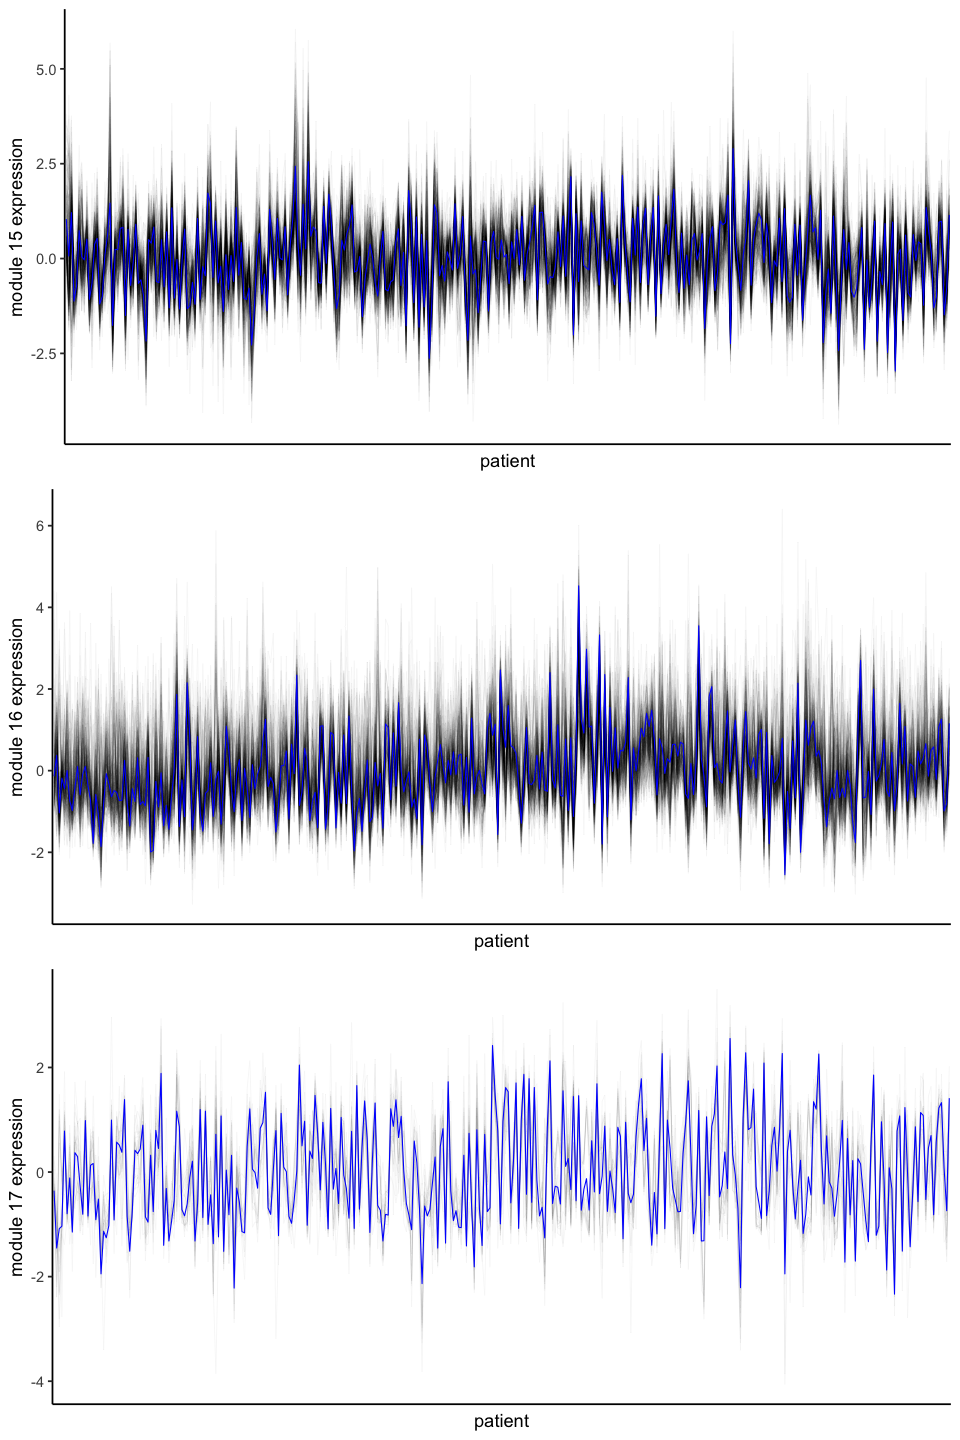

In [84]:
options(repr.plot.width=8, repr.plot.height=12)
plot_grid(plotlist=p.list, ncol=1)